In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/case-combined/merged_subjects_data.csv


In [2]:
data = pd.read_csv('/kaggle/input/case-combined/merged_subjects_data.csv')

In [3]:
data

,time,valence,arousal,video_x,Emotion,ecg,bvp,gsr,rsp,skt,emg_zygo,emg_coru,emg_trap,video_y,SUBJECT,AGE,GENDER,EMOTION,video_name,vid_emotion
0,1061504,-1276.0,6252.0,8.0,Frustrated or Impatient,0.76062,35.053549,4.384464,27.174558,28.863552,7.86300,6.13825,5.31675,8.0,1,30-34,F,scary,Mama (2008),scary-2
1,1061554,-1276.0,6252.0,8.0,Frustrated or Impatient,0.79018,35.005141,4.360800,27.193884,28.849530,7.94525,5.76850,5.15250,8.0,1,30-34,F,scary,Mama (2008),scary-2
2,1061604,-1276.0,6268.0,8.0,Frustrated or Impatient,0.80990,35.809029,4.380504,27.213270,28.860030,8.06850,5.72750,5.02950,8.0,1,30-34,F,scary,Mama (2008),scary-2
3,1061654,-1276.0,6268.0,8.0,Frustrated or Impatient,0.83946,37.368456,4.384464,27.281031,28.863552,7.37025,6.09725,5.31675,8.0,1,30-34,F,scary,Mama (2008),scary-2
4,1061704,-1276.0,6288.0,8.0,Frustrated or Impatient,0.79018,37.145698,4.356864,27.271309,28.863552,7.65775,5.89175,5.11150,8.0,1,30-34,F,scary,Mama (2008),scary-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196278,2231442,0.0,0.0,7.0,Neutral,1.05632,37.949645,37.403472,46.155954,29.852173,5.39900,7.53450,5.89175,7.0,29,25-29,M,scary,Shutter (2004),scary-1
196279,2231492,0.0,0.0,7.0,Neutral,0.81318,37.542807,37.419240,46.223715,29.852173,5.64550,7.98625,5.85075,7.0,29,25-29,M,scary,Shutter (2004),scary-1
196280,2231542,0.0,0.0,7.0,Neutral,0.82632,36.961677,37.320672,46.301140,29.845152,5.56325,7.41125,5.72750,7.0,29,25-29,M,scary,Shutter (2004),scary-1
196281,2231592,0.0,0.0,7.0,Neutral,0.83290,36.516101,37.407408,46.397951,29.862694,5.76850,7.57550,5.80975,12.0,29,25-29,M,scary,Shutter (2004),scary-1


# Pre-processing steps

In [4]:
data['Emotion'].unique()

array(['Frustrated or Impatient', 'Tensed or Annoyed',
       'Distressed or Defiant', 'Neutral', 'Confident or Attentive',
       'Passionate or Amused', 'Pleased or Glad', 'Delighted or Happy',
       'Worried or Apathetic', 'Frustrated or Discontented',
       'Aroused or Astonished', 'Miserable or Sad', 'Anxious or Dejected',
       'Tired or Bored', 'Polite or Sleepy', 'Excited or Adventurous'],
      dtype=object)

In [5]:
# Define positive and negative emotions
positive_emotions = [
    'Confident or Attentive', 'Passionate or Amused', 'Pleased or Glad', 
    'Delighted or Happy', 'Excited or Adventurous', 'Polite or Sleepy', 
    'Neutral', 'Aroused or Astonished'
]

# Add a new column 'Emotion_Type' to classify emotions as Positive or Negative
data['Emotion_Type'] = data['Emotion'].apply(
    lambda x: 'Positive' if x in positive_emotions else 'Negative'
)
# Define the columns to retain
columns_to_keep = [
    'ecg', 'bvp', 'gsr', 'rsp', 'skt', 'emg_coru', 'emg_trap', 'emg_zygo',  # 8 physio features
    'Emotion', 'AGE', 'GENDER', 'Emotion_Type'  # Other required columns
]

# Create a new DataFrame retaining only the specified columns
data = data[columns_to_keep]

In [6]:
data

,ecg,bvp,gsr,rsp,skt,emg_coru,emg_trap,emg_zygo,Emotion,AGE,GENDER,Emotion_Type
0,0.76062,35.053549,4.384464,27.174558,28.863552,6.13825,5.31675,7.86300,Frustrated or Impatient,30-34,F,Negative
1,0.79018,35.005141,4.360800,27.193884,28.849530,5.76850,5.15250,7.94525,Frustrated or Impatient,30-34,F,Negative
2,0.80990,35.809029,4.380504,27.213270,28.860030,5.72750,5.02950,8.06850,Frustrated or Impatient,30-34,F,Negative
3,0.83946,37.368456,4.384464,27.281031,28.863552,6.09725,5.31675,7.37025,Frustrated or Impatient,30-34,F,Negative
4,0.79018,37.145698,4.356864,27.271309,28.863552,5.89175,5.11150,7.65775,Frustrated or Impatient,30-34,F,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...
196278,1.05632,37.949645,37.403472,46.155954,29.852173,7.53450,5.89175,5.39900,Neutral,25-29,M,Positive
196279,0.81318,37.542807,37.419240,46.223715,29.852173,7.98625,5.85075,5.64550,Neutral,25-29,M,Positive
196280,0.82632,36.961677,37.320672,46.301140,29.845152,7.41125,5.72750,5.56325,Neutral,25-29,M,Positive
196281,0.83290,36.516101,37.407408,46.397951,29.862694,7.57550,5.80975,5.76850,Neutral,25-29,M,Positive


Gender and Age Distribution (Heatmap Data):
AGE     20-24  25-29  30-34  35-39
GENDER                            
F       47654  32822  13625      0
M       20440  61304   6812  13626
Total Instances: 196283


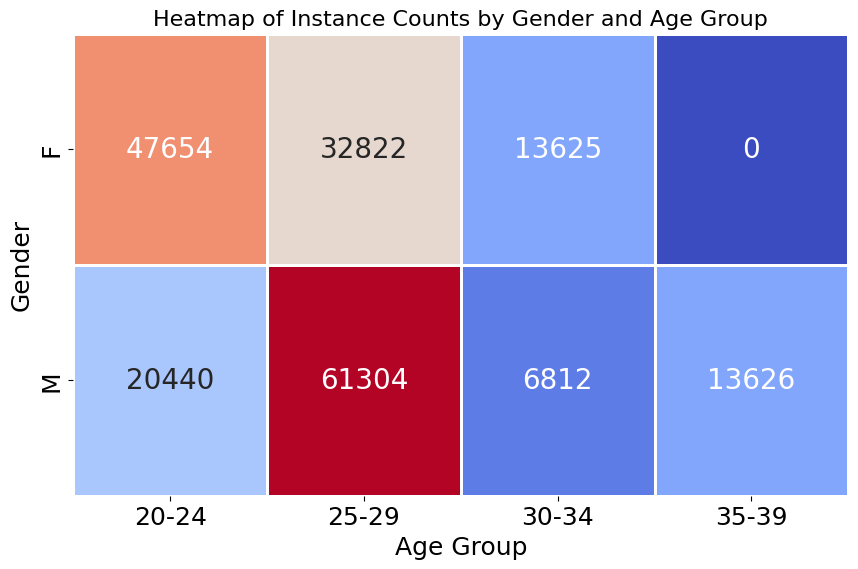


Emotion Type Counts and Percentages:
Emotion
Neutral                       108843
Confident or Attentive         18418
Passionate or Amused           17212
Frustrated or Impatient        16325
Distressed or Defiant          11175
Worried or Apathetic            6601
Tensed or Annoyed               4845
Delighted or Happy              4296
Pleased or Glad                 2963
Frustrated or Discontented      1823
Tired or Bored                  1195
Aroused or Astonished           1152
Polite or Sleepy                 982
Miserable or Sad                 247
Anxious or Dejected              157
Excited or Adventurous            49
Name: count, dtype: int64
Emotion
Neutral                       55.452077
Confident or Attentive         9.383390
Passionate or Amused           8.768971
Frustrated or Impatient        8.317073
Distressed or Defiant          5.693310
Worried or Apathetic           3.363001
Tensed or Annoyed              2.468375
Delighted or Happy             2.188677
Pleased 

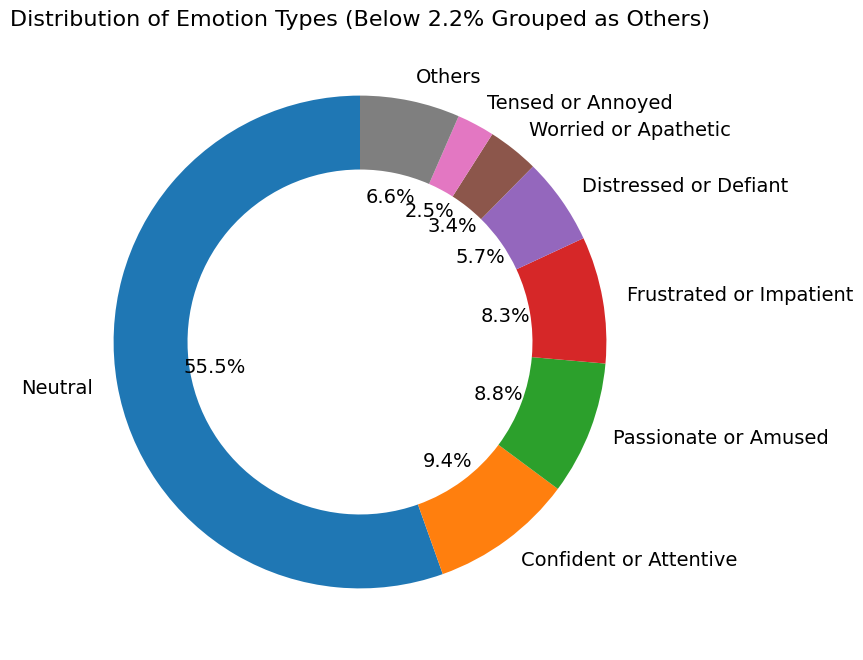


Number of Instances with 'Neutral': 108843

Emotion Type Counts (Excluding Neutral):
Emotion
Confident or Attentive        18418
Passionate or Amused          17212
Frustrated or Impatient       16325
Distressed or Defiant         11175
Worried or Apathetic           6601
Tensed or Annoyed              4845
Delighted or Happy             4296
Pleased or Glad                2963
Frustrated or Discontented     1823
Tired or Bored                 1195
Aroused or Astonished          1152
Polite or Sleepy                982
Miserable or Sad                247
Anxious or Dejected             157
Excited or Adventurous           49
Name: count, dtype: int64
Total Instances (Excluding Neutral): 87440
Emotion Type Percentages (Excluding Neutral):
Emotion
Confident or Attentive        21.063586
Passionate or Amused          19.684355
Frustrated or Impatient       18.669945
Distressed or Defiant         12.780192
Worried or Apathetic           7.549177
Tensed or Annoyed              5.540942
Del

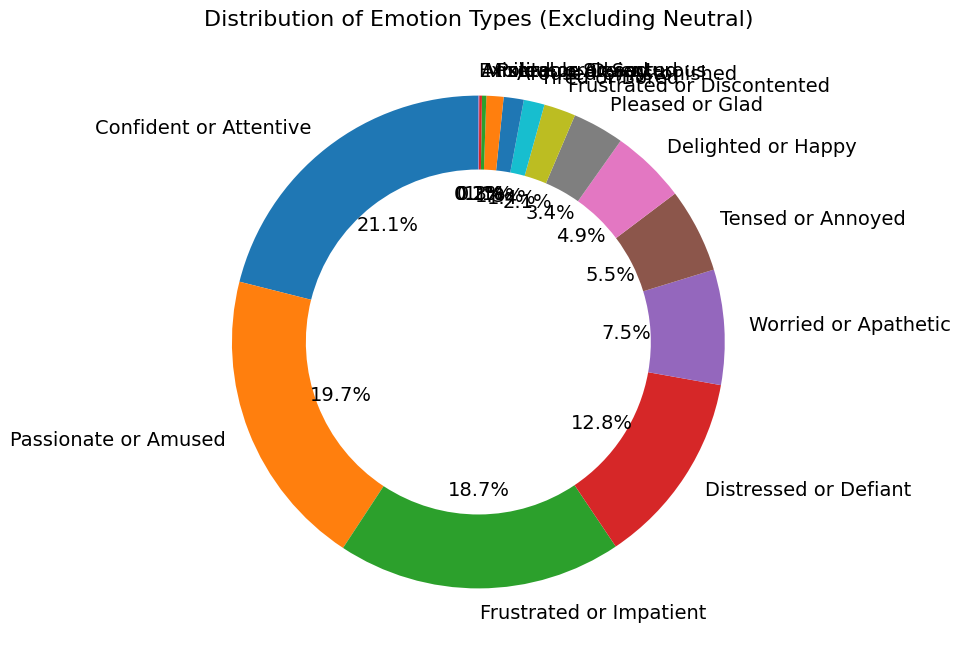


Age Group Distribution:
AGE
25-29    94126
20-24    68094
30-34    20437
35-39    13626
Name: count, dtype: int64
Total Instances in Age Groups: 196283


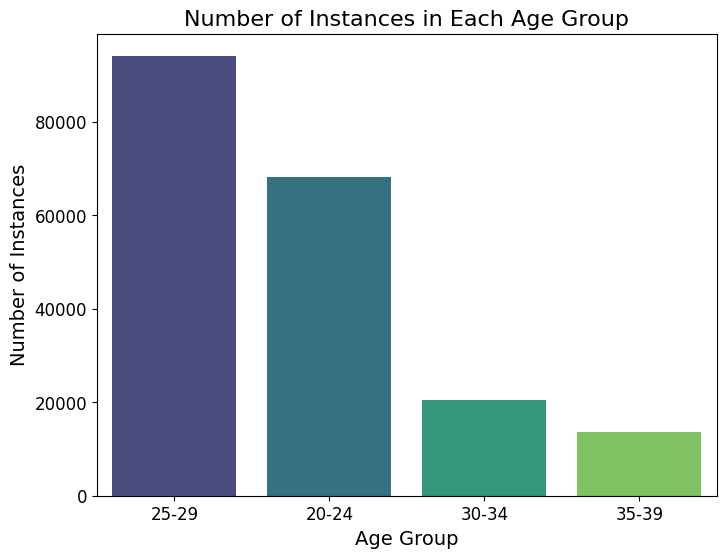


Gender Distribution:
GENDER
M    102182
F     94101
Name: count, dtype: int64
Total Instances in Gender Classes: 196283


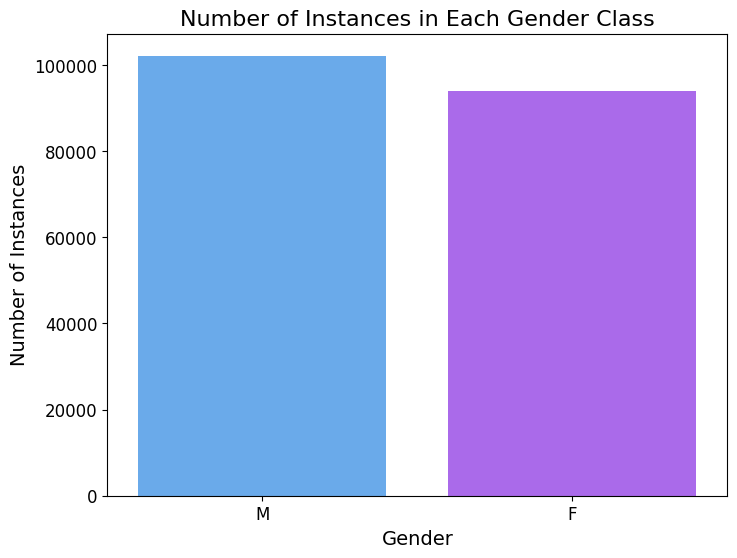

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Example DataFrame (replace with your dataset)
# data = pd.read_csv("your_data.csv")

# 1. Heatmap for Gender and Age Distribution
plt.figure(figsize=(10, 6))

# Grouping data by Gender and Age and calculating the count
heatmap_data = data.groupby(['GENDER', 'AGE']).size().unstack(fill_value=0)

# Print the heatmap data and total count
print("Gender and Age Distribution (Heatmap Data):")
print(heatmap_data)
print(f"Total Instances: {heatmap_data.sum().sum()}")  # Total instances in the heatmap data

# Create the heatmap
sns.heatmap(
    heatmap_data, annot=True, cmap='coolwarm', fmt='d', linewidths=1, cbar=False,
    annot_kws={"size": 20}  # Adjust text size
)
plt.title('Heatmap of Instance Counts by Gender and Age Group', fontsize=16)
plt.xlabel('Age Group', fontsize=18)
plt.ylabel('Gender', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

# 2. Donut Chart for Emotion_Type Distribution (with threshold)
percentage_threshold = 2.2  # Set the percentage threshold (e.g., 5%)
emotion_type_counts = data['Emotion'].value_counts()

# Calculate percentages
total_count = emotion_type_counts.sum()
emotion_type_percentages = (emotion_type_counts / total_count) * 100

# Print the emotion type counts, percentages, and total instances
print("\nEmotion Type Counts and Percentages:")
print(emotion_type_counts)
print(emotion_type_percentages)
print(f"Total Instances: {total_count}")  # Total instances in emotion type data

# Group smaller categories
emotion_type_counts_filtered = emotion_type_counts[emotion_type_percentages >= percentage_threshold]
others_count = emotion_type_counts[emotion_type_percentages < percentage_threshold].sum()
if others_count > 0:
    emotion_type_counts_filtered["Others"] = others_count

# Plot the initial donut chart
plt.figure(figsize=(8, 8))
plt.pie(
    emotion_type_counts_filtered, labels=emotion_type_counts_filtered.index, autopct='%1.1f%%', 
    startangle=90, textprops={'fontsize': 14}, wedgeprops={'width': 0.3}
)
plt.title(f'Distribution of Emotion Types (Below {percentage_threshold}% Grouped as Others)', fontsize=16)
plt.show()

# 3. Remove 'Neutral' instances and plot donut chart again
# Print the count of 'Neutral' instances before excluding
neutral_count = data[data['Emotion'] == 'Neutral'].shape[0]
print(f"\nNumber of Instances with 'Neutral': {neutral_count}")

# Remove 'Neutral' instances
data_no_neutral = data[data['Emotion'] != 'Neutral']

# Recalculate emotion type counts and percentages for non-neutral instances
emotion_type_counts_no_neutral = data_no_neutral['Emotion'].value_counts()

# Print the filtered emotion type counts and total instances
print("\nEmotion Type Counts (Excluding Neutral):")
print(emotion_type_counts_no_neutral)
print(f"Total Instances (Excluding Neutral): {emotion_type_counts_no_neutral.sum()}")  # Total instances excluding 'Neutral'

# Calculate percentages for non-neutral instances
emotion_type_percentages_no_neutral = (emotion_type_counts_no_neutral / emotion_type_counts_no_neutral.sum()) * 100
print("Emotion Type Percentages (Excluding Neutral):")
print(emotion_type_percentages_no_neutral)

# Plot the donut chart again without Neutral instances
plt.figure(figsize=(8, 8))
plt.pie(
    emotion_type_counts_no_neutral, labels=emotion_type_counts_no_neutral.index, autopct='%1.1f%%', 
    startangle=90, textprops={'fontsize': 14}, wedgeprops={'width': 0.3}
)
plt.title('Distribution of Emotion Types (Excluding Neutral)', fontsize=16)
plt.show()

# 4. Bar Plot for Age Group Distribution
plt.figure(figsize=(8, 6))

# Count the instances for each age group
age_counts = data['AGE'].value_counts()

# Print the age group distribution and total instances
print("\nAge Group Distribution:")
print(age_counts)
print(f"Total Instances in Age Groups: {age_counts.sum()}")  # Total instances in age groups

# Create the bar plot
sns.barplot(
    x=age_counts.index,
    y=age_counts.values,
    palette='viridis'
)
plt.title('Number of Instances in Each Age Group', fontsize=16)
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Number of Instances', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# 5. Bar Plot for Gender Distribution
plt.figure(figsize=(8, 6))

# Count the instances for each gender
gender_counts = data['GENDER'].value_counts()

# Print the gender distribution and total instances
print("\nGender Distribution:")
print(gender_counts)
print(f"Total Instances in Gender Classes: {gender_counts.sum()}")  # Total instances in gender classes

# Create the bar plot
sns.barplot(
    x=gender_counts.index,
    y=gender_counts.values,
    palette='cool'
)
plt.title('Number of Instances in Each Gender Class', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Number of Instances', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


Missing values before cleaning:
ecg             1
bvp             1
gsr             1
rsp             1
skt             1
emg_coru        1
emg_trap        1
emg_zygo        1
Emotion         0
AGE             0
GENDER          0
Emotion_Type    0
dtype: int64

Missing values after cleaning:
ecg             1
bvp             1
gsr             1
rsp             1
skt             1
emg_coru        1
emg_trap        1
emg_zygo        1
Emotion         0
AGE             0
GENDER          0
Emotion_Type    0
dtype: int64
Target size per class: 3629

Old Emotion Class Distribution (excluding neutral):
Emotion
Confident or Attentive        18418
Passionate or Amused          17212
Frustrated or Impatient       16325
Distressed or Defiant         11175
Worried or Apathetic           6601
Tensed or Annoyed              4845
Delighted or Happy             4296
Pleased or Glad                2963
Frustrated or Discontented     1823
Tired or Bored                 1195
Aroused or Astonished        

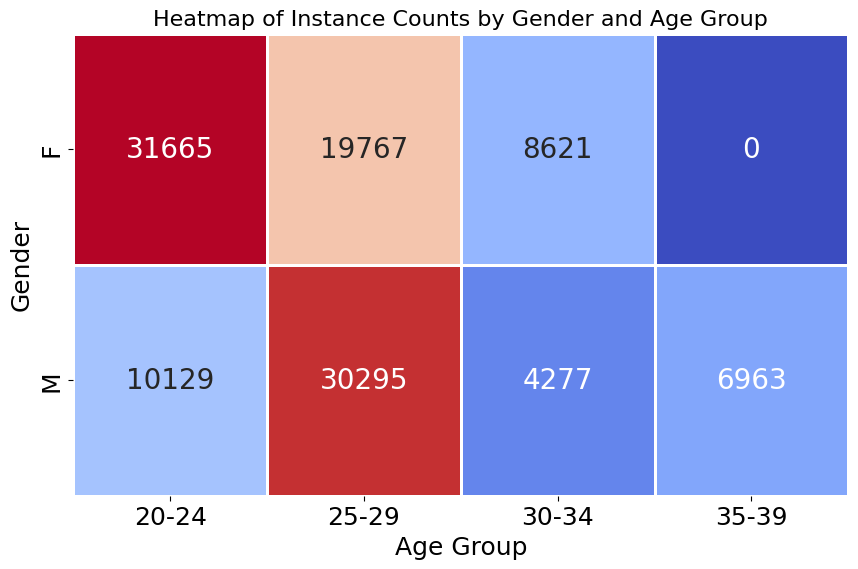


Emotion Distribution Information:
Emotion
Confident or Attentive        18418
Passionate or Amused          17212
Frustrated or Impatient       16325
Distressed or Defiant         11175
Worried or Apathetic           6601
Tensed or Annoyed              4845
Delighted or Happy             4296
Frustrated or Discontented     3792
Aroused or Astonished          3743
Polite or Sleepy               3718
Excited or Adventurous         3634
Miserable or Sad               3632
Neutral                        3629
Pleased or Glad                3626
Anxious or Dejected            3625
Tired or Bored                 3581
Name: count, dtype: int64
Total Instances in Emotion Distribution: 111852
Percentages for each class:
Emotion
Confident or Attentive        16.466402
Passionate or Amused          15.388192
Frustrated or Impatient       14.595179
Distressed or Defiant          9.990881
Worried or Apathetic           5.901548
Tensed or Annoyed              4.331617
Delighted or Happy             

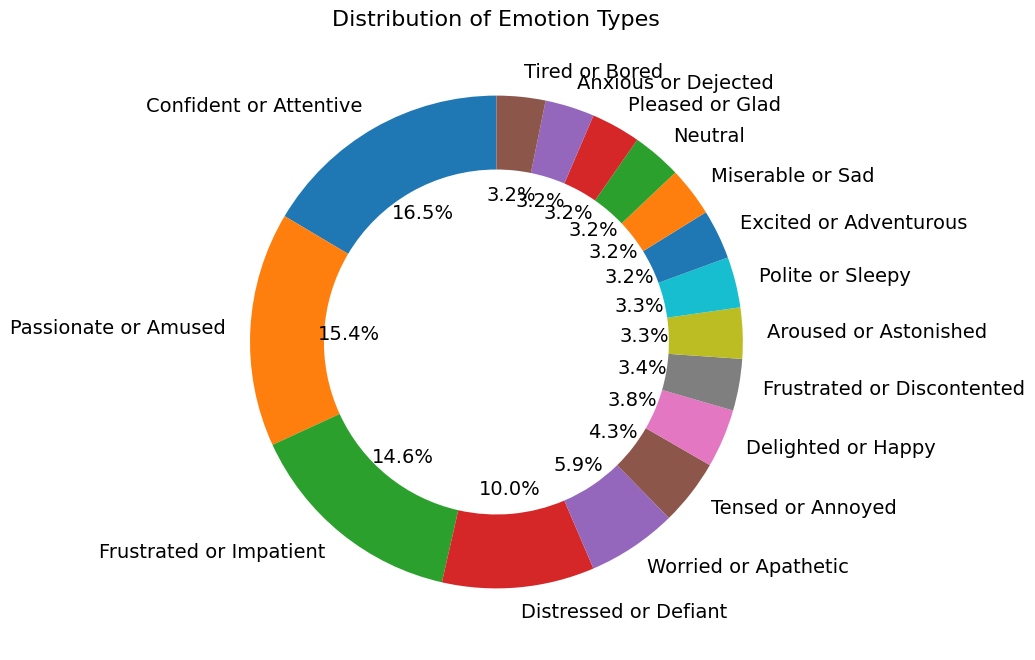


Age Group Distribution Information:
AGE
25-29    50063
20-24    41803
30-34    12898
35-39     6963
Name: count, dtype: int64
Total Instances in Age Group Distribution: 111727

Old vs New Age Group Counts (excluding Neutral):
25-29: Old=94126, New=50063, Difference=-44063
20-24: Old=68094, New=41803, Difference=-26291
30-34: Old=20437, New=12898, Difference=-7539
35-39: Old=13626, New=6963, Difference=-6663


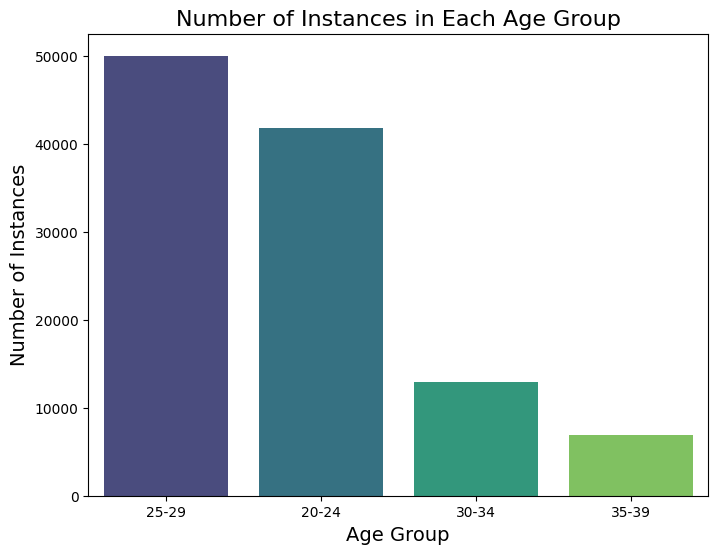


Gender Distribution Information:
GENDER
F    60097
M    51664
Name: count, dtype: int64
Total Instances in Gender Distribution: 111761

Old vs New Gender Class Counts (excluding Neutral):
M: Old=102182, New=51664, Difference=-50518
F: Old=94101, New=60097, Difference=-34004


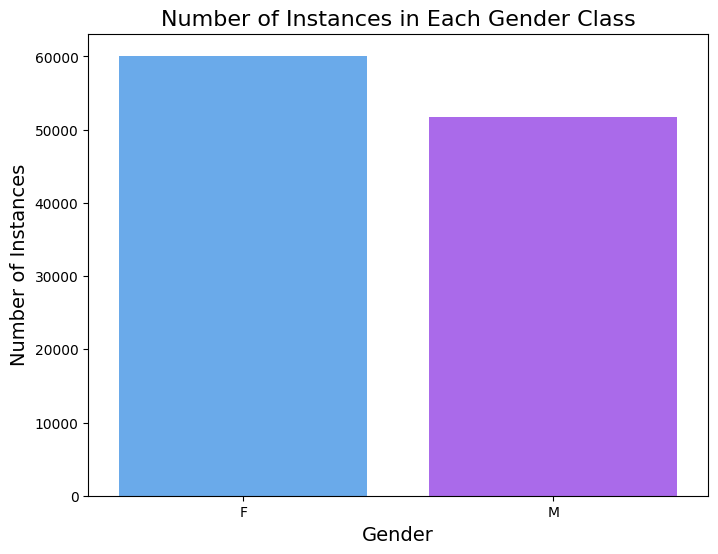

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.impute import SimpleImputer

def clean_data(data):
    """Cleans data by handling missing values in crucial columns."""
    df = data.copy()
    print("Missing values before cleaning:")
    print(df.isnull().sum())
    
    # Drop rows where crucial columns ('Emotion', 'GENDER', 'AGE') have missing values
    crucial_columns = ['Emotion', 'GENDER', 'AGE']
    df = df.dropna(subset=crucial_columns)
    
    print("\nMissing values after cleaning:")
    print(df.isnull().sum())
    return df

def balance_emotion_data(data):
    """Balances the Emotion data using ADASYN or SMOTE."""
    
    # Create a copy of the data to avoid modifying the original data
    df = data.copy()
    
    # Separate neutral emotion data from other emotions
    neutral_mask = df['Emotion'] == 'Neutral'
    df_neutral = df[neutral_mask]
    df_others = df[~neutral_mask]
    
    # Calculate target size for balanced classes
    emotion_counts = df['Emotion'].value_counts()
    target_size = int(np.median(emotion_counts))  # Use median as target size for balancing
    print(f"Target size per class: {target_size}")
    
    # Print old number of instances per class (excluding neutral instances)
    print("\nOld Emotion Class Distribution (excluding neutral):")
    emotion_counts_excluding_neutral = emotion_counts.drop('Neutral', errors='ignore')
    print(emotion_counts_excluding_neutral)
    print(f"Total Instances before balancing: {emotion_counts_excluding_neutral.sum()}")

    # Undersample neutral class to target size
    if len(df_neutral) > target_size:
        neutral_indices = np.random.choice(df_neutral.index, target_size, replace=False)
        df_neutral_balanced = df_neutral.loc[neutral_indices]
    else:
        df_neutral_balanced = df_neutral
    
    # Prepare the data for resampling
    df_combined = pd.concat([df_neutral_balanced, df_others])
    X = df_combined.drop(['Emotion', 'Emotion_Type'], axis=1)
    y = df_combined['Emotion']
    
    # Convert categorical variables to numeric codes
    X['GENDER'] = pd.Categorical(X['GENDER']).codes
    X['AGE'] = pd.Categorical(X['AGE']).codes
    
    # Handle missing values in numeric columns
    numeric_columns = X.select_dtypes(include=[np.number]).columns
    imputer = SimpleImputer(strategy='mean')
    X_imputed = X.copy()
    X_imputed[numeric_columns] = imputer.fit_transform(X[numeric_columns])
    
    # Handle missing values in target variable 'y' if any
    y = y.fillna(y.mode()[0])
    
    # Create sampling strategy dictionary to control synthetic data generation
    sampling_strategy = {}
    for emotion in y.unique():
        count = Counter(y)[emotion]
        if count < target_size:
            sampling_strategy[emotion] = target_size
    
    # Apply ADASYN for resampling
    try:
        adasyn = ADASYN(random_state=42, n_neighbors=5, sampling_strategy=sampling_strategy)
        X_resampled, y_resampled = adasyn.fit_resample(X_imputed, y)
        
        # Print new number of instances after balancing
        print("\nNew Emotion Class Distribution (after ADASYN or SMOTE):")
        print(Counter(y_resampled))
        print(f"Total Instances after balancing: {sum(Counter(y_resampled).values())}")
        
    except ValueError as e:
        print(f"ADASYN failed with error: {str(e)}")
        print("Falling back to SMOTE...")
        from imblearn.over_sampling import SMOTE
        smote = SMOTE(random_state=42, sampling_strategy=sampling_strategy)
        X_resampled, y_resampled = smote.fit_resample(X_imputed, y)

    # Convert back to DataFrame
    df_resampled = pd.DataFrame(X_resampled, columns=X_imputed.columns)
    df_resampled['Emotion'] = y_resampled
    
    # Convert numeric values back to categorical
    gender_map = {0: 'F', 1: 'M'}
    age_map = {0: '20-24', 1: '25-29', 2: '30-34', 3: '35-39'}
    
    df_resampled['GENDER'] = df_resampled['GENDER'].map(gender_map)
    df_resampled['AGE'] = df_resampled['AGE'].map(age_map)
    print(df_resampled.head())
    
    # Add back 'Emotion_Type'
    emotion_type_map = dict(zip(data['Emotion'], data['Emotion_Type']))
    df_resampled['Emotion_Type'] = df_resampled['Emotion'].map(emotion_type_map)
    
    return df_resampled, df

def create_visualizations(data, old_data):
    """Creates visualizations for the dataset."""
    
    # 1. Heatmap for Gender and Age Distribution
    print("\nHeatmap Information:")
    heatmap_data = data.groupby(['GENDER', 'AGE']).size().unstack(fill_value=0)
    print(heatmap_data)
    print(f"Total Instances in Heatmap: {heatmap_data.sum().sum()}")  # Total instances in the heatmap data
    
    # Print differences (excluding neutral)
    old_heatmap_data = old_data.groupby(['GENDER', 'AGE']).size().unstack(fill_value=0)
    old_heatmap_data_excluding_neutral = old_heatmap_data.drop('Neutral', errors='ignore')
    print("\nOld vs New Heatmap Data (excluding Neutral):")
    print(old_heatmap_data_excluding_neutral.sum().sum(), " (Old) vs", heatmap_data.sum().sum(), " (New)")
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        heatmap_data, annot=True, cmap='coolwarm', fmt='d', linewidths=1, cbar=False,
        annot_kws={"size": 20}
    )
    plt.title('Heatmap of Instance Counts by Gender and Age Group', fontsize=16)
    plt.xlabel('Age Group', fontsize=18)
    plt.ylabel('Gender', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

    # 2. Donut Chart for Emotion Distribution
    print("\nEmotion Distribution Information:")
    emotion_counts = data['Emotion'].value_counts()
    total_count = emotion_counts.sum()
    emotion_percentages = (emotion_counts / total_count) * 100
    print(emotion_counts)
    print(f"Total Instances in Emotion Distribution: {total_count}")  # Total instances in emotion data
    print("Percentages for each class:")
    print(emotion_percentages)
    
    # Print the difference in Emotion Classes (excluding Neutral)
    old_emotion_counts = old_data['Emotion'].value_counts()
    old_emotion_counts_excluding_neutral = old_emotion_counts.drop('Neutral', errors='ignore')
    print(f"Old Emotion Instances (excluding Neutral): {old_emotion_counts_excluding_neutral}")
    
    # Ignore neutral instances in old data count for diff calculation
    print("\nOld vs New Emotion Class Counts (excluding Neutral):")
    for emotion in old_emotion_counts_excluding_neutral.index:
        old_count = old_emotion_counts_excluding_neutral[emotion]
        new_count = emotion_counts.get(emotion, 0)
        diff = new_count - old_count
        print(f"{emotion}: Old={old_count}, New={new_count}, Difference={diff}")
    
    plt.figure(figsize=(8, 8))
    plt.pie(
        emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%',
        startangle=90, textprops={'fontsize': 14}, wedgeprops={'width': 0.3}
    )
    plt.title('Distribution of Emotion Types', fontsize=16)
    plt.show()

    # 3. Bar Plot for Age Group Distribution
    print("\nAge Group Distribution Information:")
    age_counts = data['AGE'].value_counts()
    print(age_counts)
    print(f"Total Instances in Age Group Distribution: {age_counts.sum()}")  # Total instances in age groups
    
    # Print differences in age groups (excluding neutral)
    old_age_counts = old_data['AGE'].value_counts()
    old_age_counts_excluding_neutral = old_age_counts.drop('Neutral', errors='ignore')
    print("\nOld vs New Age Group Counts (excluding Neutral):")
    for age_group in old_age_counts_excluding_neutral.index:
        old_count = old_age_counts_excluding_neutral[age_group]
        new_count = age_counts.get(age_group, 0)
        diff = new_count - old_count
        print(f"{age_group}: Old={old_count}, New={new_count}, Difference={diff}")
    
    plt.figure(figsize=(8, 6))
    sns.barplot(
        x=age_counts.index,
        y=age_counts.values,
        palette='viridis'
    )
    plt.title('Number of Instances in Each Age Group', fontsize=16)
    plt.xlabel('Age Group', fontsize=14)
    plt.ylabel('Number of Instances', fontsize=14)
    plt.show()

    # 4. Bar Plot for Gender Distribution
    print("\nGender Distribution Information:")
    gender_counts = data['GENDER'].value_counts()
    print(gender_counts)
    print(f"Total Instances in Gender Distribution: {gender_counts.sum()}")  # Total instances in gender classes
    
    # Print differences in gender classes (excluding neutral)
    old_gender_counts = old_data['GENDER'].value_counts()
    old_gender_counts_excluding_neutral = old_gender_counts.drop('Neutral', errors='ignore')
    print("\nOld vs New Gender Class Counts (excluding Neutral):")
    for gender in old_gender_counts_excluding_neutral.index:
        old_count = old_gender_counts_excluding_neutral[gender]
        new_count = gender_counts.get(gender, 0)
        diff = new_count - old_count
        print(f"{gender}: Old={old_count}, New={new_count}, Difference={diff}")
    
    plt.figure(figsize=(8, 6))
    sns.barplot(
        x=gender_counts.index,
        y=gender_counts.values,
        palette='cool'
    )
    plt.title('Number of Instances in Each Gender Class', fontsize=16)
    plt.xlabel('Gender', fontsize=14)
    plt.ylabel('Number of Instances', fontsize=14)
    plt.show()

# Example workflow (replace 'data' with your dataset)
# data = pd.read_csv("your_dataset.csv")
cleaned_data = clean_data(data)
balanced_data, old_data = balance_emotion_data(cleaned_data)
create_visualizations(balanced_data, old_data)


In [9]:
balanced_data

,ecg,bvp,gsr,rsp,skt,emg_coru,emg_trap,emg_zygo,AGE,GENDER,Emotion,Emotion_Type
0,0.747480,35.363512,27.921528,32.140117,24.463827,6.015000,13.900000,4.865000,20-24,M,Neutral,Positive
1,0.865760,37.048823,9.024816,35.953790,24.583016,5.563250,6.384750,5.399000,25-29,F,Neutral,Positive
2,0.688340,36.554839,29.321136,43.348921,30.241305,16.487250,29.177250,416.945250,25-29,M,Neutral,Positive
3,0.320360,37.310379,16.988784,38.935058,31.573496,12.586000,20.594250,5.070500,25-29,F,Neutral,Positive
4,0.642340,36.138391,24.799008,37.328287,32.246612,5.563250,5.974000,5.152500,25-29,M,Neutral,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...
111847,0.772180,34.939282,15.706037,42.739491,28.524633,5.301728,6.029046,4.988988,25-29,M,Tired or Bored,Negative
111848,0.691566,34.767266,15.758172,42.691009,28.527442,5.734226,6.142284,4.870384,25-29,M,Tired or Bored,Negative
111849,0.740080,34.668381,15.753460,42.803862,28.528516,6.188880,6.115187,4.700130,25-29,M,Tired or Bored,Negative
111850,0.751840,34.653223,15.750813,42.777865,28.531658,6.124611,6.151937,4.782857,25-29,M,Tired or Bored,Negative


In [10]:
df = balanced_data

# Gated Recurrent Unit - GRU model 

In [11]:
pip install aif360

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 7.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 6.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [13]:
balanced_data['Emotion'].unique()

array(['Neutral', 'Frustrated or Impatient', 'Tensed or Annoyed',
       'Distressed or Defiant', 'Confident or Attentive',
       'Passionate or Amused', 'Pleased or Glad', 'Delighted or Happy',
       'Worried or Apathetic', 'Frustrated or Discontented',
       'Aroused or Astonished', 'Miserable or Sad', 'Anxious or Dejected',
       'Tired or Bored', 'Polite or Sleepy', 'Excited or Adventurous'],
      dtype=object)

Loading data...
Data loaded successfully.
Checking for missing values...
ecg               0
bvp               0
gsr               0
rsp               0
skt               0
emg_coru          0
emg_trap          0
emg_zygo          0
AGE             125
GENDER           91
Emotion           0
Emotion_Type      0
dtype: int64
Dropping missing values...
Remaining data shape after cleaning: (111717, 12)

Training optimized model...


<ipython-input-14-9e2c83b4e43d>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[target] = emotion_encoder.fit_transform(df_cleaned[target])
<ipython-input-14-9e2c83b4e43d>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[feature] = label_encoder.fit_transform(df_cleaned[feature])
<ipython-input-14-9e2c83b4e43d>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


559/559 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.5408 - loss: 1.5048 - val_accuracy: 0.7949 - val_loss: 0.5641
Epoch 2/100
559/559 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7268 - loss: 0.7352 - val_accuracy: 0.8205 - val_loss: 0.4676
Epoch 3/100
559/559 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7667 - loss: 0.6174 - val_accuracy: 0.8350 - val_loss: 0.4306
Epoch 4/100
559/559 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7902 - loss: 0.5533 - val_accuracy: 0.8442 - val_loss: 0.4060
Epoch 5/100
559/559 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7959 - loss: 0.5347 - val_accuracy: 0.8530 - val_loss: 0.3913
Epoch 6/100
559/559 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.8061 - loss: 0.5067 - val_accuracy: 0.8512 - val_loss: 0.3894
Epoch 7/100
559/559 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.8080 - loss: 0.4986 - val_accuracy: 0.8496 - val_loss: 0.3874
Epoch 8/100
559/559 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.8171 - loss: 0.4751 - val_accurac

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Overall Optimized Model Performance:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       687
           1       0.84      0.96      0.90       738
           2       0.91      0.89      0.90      3738
           3       0.91      0.82      0.86       868
           4       0.94      0.95      0.94      2212
           5       0.99      1.00      0.99       731
           6       0.74      0.72      0.73       773
           7       0.91      0.90      0.90      3245
           8       0.93      0.97      0.95       693
           9       0.92      0.64      0.76       750
          10       0.92      0.92      0.92      3500
          11       0.81      0.92      0.86       717
          12       0.83      1.00      0.91       772
          13       0.83      0.83      0.83       908
          14       0.93      0.95      0.94       726
          15       0.93      0.90      0.92      1286

 

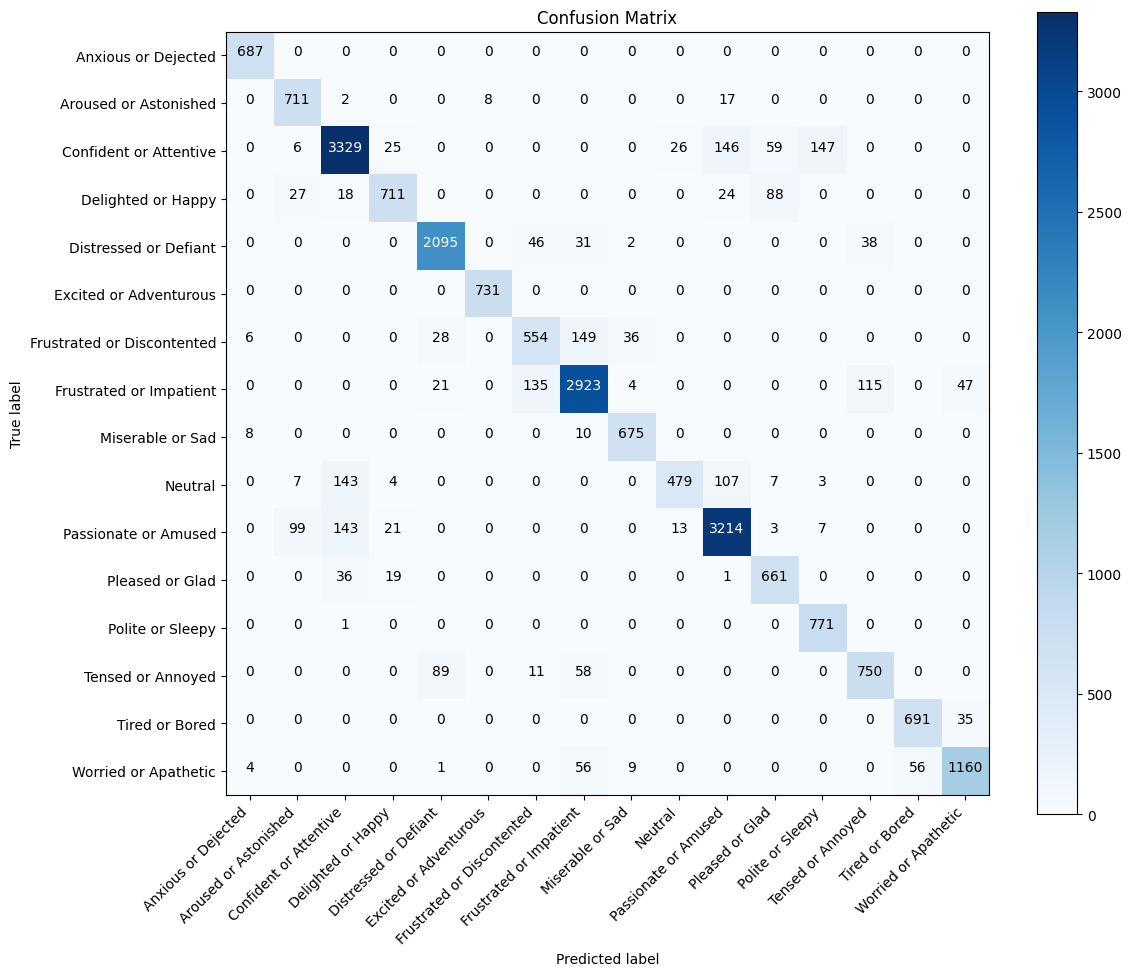

699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Fairness metrics for Age:
Accuracy by Age: {0: 0.9002859185132237, 1: 0.8946529921338245, 3: 0.9097525473071325, 2: 0.927753651796289}
Demographic Parity Difference: 0.033
Equal Opportunity Difference: 0.033
Separation: 0.013

699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Fairness metrics for Gender:
Accuracy by Gender: {1: 0.9082719876017048, 0: 0.8955906821963394}
Demographic Parity Difference: 0.013
Equal Opportunity Difference: 0.013
Separation: 0.006



In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, Attention, Add
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


class OptimizedGRUModel:
    """
    Optimized GRU model with attention, residual connections, and multiple layers for high accuracy.
    """
    def __init__(self, input_size, hidden_size, output_size):
        # Encoder part (Bidirectional GRU + Attention)
        encoder_inputs = Input(shape=(None, input_size))  # None for time steps

        # First Bidirectional GRU Layer
        encoder_gru1 = Bidirectional(GRU(hidden_size, return_sequences=True))(encoder_inputs)
        encoder_gru1 = BatchNormalization()(encoder_gru1)
        encoder_gru1 = Dropout(0.4)(encoder_gru1)

        # Second Bidirectional GRU Layer
        encoder_gru2 = Bidirectional(GRU(hidden_size, return_sequences=True))(encoder_gru1)
        encoder_gru2 = BatchNormalization()(encoder_gru2)
        encoder_gru2 = Dropout(0.4)(encoder_gru2)

        # Attention Mechanism
        attention_output = Attention()([encoder_gru2, encoder_gru2])

        # Residual Connection between encoder output and attention output
        residual = Add()([encoder_gru2, attention_output])

        # Decoder part (LSTM)
        decoder_lstm = LSTM(hidden_size)(residual)
        decoder_lstm = BatchNormalization()(decoder_lstm)
        decoder_lstm = Dropout(0.5)(decoder_lstm)

        # Output layer (Fully connected)
        decoder_outputs = Dense(output_size, activation='softmax')(decoder_lstm)

        # Model definition
        self.model = Model(inputs=encoder_inputs, outputs=decoder_outputs)
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                           loss='categorical_crossentropy', 
                           metrics=['accuracy'])

    def fit(self, X, y, sample_weight=None, validation_split=0.2, callbacks=None):
        X_reshaped = X.reshape(-1, 1, X.shape[1])  # Reshape for time series (batch, time_steps, features)
        early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

        if callbacks is None:
            callbacks = []
        callbacks.extend([early_stopping])

        self.model.fit(
            X_reshaped, y, 
            sample_weight=sample_weight, 
            batch_size=128, 
            epochs=100, 
            verbose=1, 
            validation_split=validation_split, 
            callbacks=callbacks
        )
        return self

    def predict(self, X):
        X_reshaped = X.reshape(-1, 1, X.shape[1])
        return self.model.predict(X_reshaped)


def preprocess_data(df_cleaned):
    """
    Preprocess the data for multiclass emotion classification.
    """
    sensitive_features = ['GENDER', 'AGE']
    target = 'Emotion'
    
    emotion_encoder = LabelEncoder()
    df_cleaned[target] = emotion_encoder.fit_transform(df_cleaned[target])
    emotion_mapping = dict(zip(emotion_encoder.classes_, emotion_encoder.transform(emotion_encoder.classes_)))
    
    label_encoder = LabelEncoder()
    for feature in sensitive_features:
        df_cleaned[feature] = label_encoder.fit_transform(df_cleaned[feature])
    
    X = df_cleaned.drop(columns=sensitive_features + [target])
    for column in X.columns:
        if X[column].dtype == 'object':
            X[column] = label_encoder.fit_transform(X[column])
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    y = tf.keras.utils.to_categorical(df_cleaned[target])
    sens_features = df_cleaned[sensitive_features]
    
    return X, y, sens_features, scaler, emotion_mapping


def plot_confusion_matrix(y_true, y_pred, emotion_mapping):
    """
    Plot confusion matrix for multiclass classification.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    emotion_labels = {v: k for k, v in emotion_mapping.items()}
    tick_marks = np.arange(len(emotion_labels))
    plt.xticks(tick_marks, [emotion_labels[i] for i in range(len(emotion_labels))], rotation=45, ha='right')
    plt.yticks(tick_marks, [emotion_labels[i] for i in range(len(emotion_labels))])
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


def evaluate_fairness_metrics(model, X_test, y_test, sens_attr, attr_name, labels):
    """
    Evaluate fairness metrics like demographic parity, equal opportunity, and separation.
    """
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    results = {}
    for label in labels:
        mask = sens_attr == label
        acc = accuracy_score(y_test_classes[mask], y_pred_classes[mask])
        results[label] = acc
    
    dp_diff = np.ptp(list(results.values()))
    eo_diff = np.ptp([results[label] for label in labels])
    sep = np.std(list(results.values()))
    
    print(f"\nFairness metrics for {attr_name}:")
    print(f"Accuracy by {attr_name}: {results}")
    print(f"Demographic Parity Difference: {dp_diff:.3f}")
    print(f"Equal Opportunity Difference: {eo_diff:.3f}")
    print(f"Separation: {sep:.3f}\n")
    
    return results, dp_diff, eo_diff, sep


def train_and_evaluate_optimized(X, y, sensitive_features, age_labels, gender_labels, emotion_mapping):
    """
    Train the optimized model and evaluate its performance and fairness metrics.
    """
    X_train, X_test, y_train, y_test, sens_train, sens_test = train_test_split(
        X, y, sensitive_features, test_size=0.2, random_state=42
    )
    input_size = X_train.shape[1]
    hidden_size = 512
    output_size = y_train.shape[1]
    
    print("\nTraining optimized model...")
    optimized_model = OptimizedGRUModel(input_size, hidden_size, output_size)
    optimized_model.fit(X_train, y_train, validation_split=0.2)
    
    print("\nGenerating predictions...")
    y_pred = optimized_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    print("\nOverall Optimized Model Performance:")
    print(classification_report(y_test_classes, y_pred_classes))
    plot_confusion_matrix(y_test_classes, y_pred_classes, emotion_mapping)
    
    # Evaluate fairness metrics
    age_metrics, dp_diff_age, eo_diff_age, sep_age = evaluate_fairness_metrics(
        optimized_model, X_test, y_test, sens_test['AGE'], 'Age', age_labels
    )
    gender_metrics, dp_diff_gender, eo_diff_gender, sep_gender = evaluate_fairness_metrics(
        optimized_model, X_test, y_test, sens_test['GENDER'], 'Gender', gender_labels
    )
    
    return (age_metrics, dp_diff_age, eo_diff_age, sep_age,
            gender_metrics, dp_diff_gender, eo_diff_gender, sep_gender)


def main():
    """
    Main function to run the emotion classification system.
    """
    required_columns = [
        'ecg', 'bvp', 'gsr', 'rsp', 'skt', 'emg_coru', 'emg_trap',
        'emg_zygo', 'Emotion', 'AGE', 'GENDER'
    ]
    
    print("Loading data...")
    df = balanced_data  # Replace with your actual data loading
    print("Data loaded successfully.")
    
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        print(f"Missing required columns: {missing_columns}")
        return
    
    print("Checking for missing values...")
    print(df.isnull().sum())
    print("Dropping missing values...")
    df_cleaned = df.dropna()
    print(f"Remaining data shape after cleaning: {df_cleaned.shape}")
    
    X, y, sensitive_features, scaler, emotion_mapping = preprocess_data(df_cleaned)
    age_labels = df_cleaned['AGE'].unique()
    gender_labels = df_cleaned['GENDER'].unique()

    train_and_evaluate_optimized(X, y, sensitive_features, age_labels, gender_labels, emotion_mapping)

if __name__ == "__main__":
    main()


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, Attention, Add
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import keras_tuner as kt


class OptimizedGRUModelWithTuner:
    """
    Optimized GRU model with attention, residual connections, and tuner integration.
    """
    def build_model(self, hp, input_shape, output_shape):
        hidden_size = hp.Int("hidden_size", min_value=128, max_value=512, step=32)

        # Encoder part (Bidirectional GRU + Attention)
        encoder_inputs = Input(shape=(None, input_shape))

        # First Bidirectional GRU Layer
        encoder_gru1 = Bidirectional(GRU(hidden_size, return_sequences=True))(encoder_inputs)
        encoder_gru1 = BatchNormalization()(encoder_gru1)
        encoder_gru1 = Dropout(hp.Float("dropout_gru1", 0.2, 0.6, step=0.1))(encoder_gru1)

        # Second Bidirectional GRU Layer
        encoder_gru2 = Bidirectional(GRU(hidden_size, return_sequences=True))(encoder_gru1)
        encoder_gru2 = BatchNormalization()(encoder_gru2)
        encoder_gru2 = Dropout(hp.Float("dropout_gru2", 0.2, 0.6, step=0.1))(encoder_gru2)

        # Attention Mechanism
        attention_output = Attention()([encoder_gru2, encoder_gru2])

        # Residual Connection
        residual = Add()([encoder_gru2, attention_output])

        # Decoder part (LSTM)
        decoder_lstm = LSTM(hidden_size)(residual)
        decoder_lstm = BatchNormalization()(decoder_lstm)
        decoder_lstm = Dropout(hp.Float("dropout_lstm", 0.3, 0.7, step=0.1))(decoder_lstm)

        # Output layer
        decoder_outputs = Dense(output_shape, activation='softmax')(decoder_lstm)

        # Compile model
        model = Model(inputs=encoder_inputs, outputs=decoder_outputs)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(hp.Choice("learning_rate", values=[1e-3, 5e-4, 1e-4, 1e-5])),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model



def preprocess_data(df_cleaned):
    """
    Preprocess the data for multiclass emotion classification.
    """
    sensitive_features = ['GENDER', 'AGE']
    target = 'Emotion'
    
    emotion_encoder = LabelEncoder()
    df_cleaned[target] = emotion_encoder.fit_transform(df_cleaned[target])
    emotion_mapping = dict(zip(emotion_encoder.classes_, emotion_encoder.transform(emotion_encoder.classes_)))
    
    label_encoder = LabelEncoder()
    for feature in sensitive_features:
        df_cleaned[feature] = label_encoder.fit_transform(df_cleaned[feature])
    
    X = df_cleaned.drop(columns=sensitive_features + [target])
    for column in X.columns:
        if X[column].dtype == 'object':
            X[column] = label_encoder.fit_transform(X[column])
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    y = tf.keras.utils.to_categorical(df_cleaned[target])
    sens_features = df_cleaned[sensitive_features]
    
    return X, y, sens_features, scaler, emotion_mapping


def tune_hyperparameters(X_train, y_train):
    """
    Perform hyperparameter tuning using Keras Tuner.
    """
    input_shape = X_train.shape[1]
    output_shape = y_train.shape[1]

    def model_builder(hp):
        tuner_model = OptimizedGRUModelWithTuner()
        return tuner_model.build_model(hp, input_shape, output_shape)

    # Expand the hyperparameter ranges for tuning
    tuner = kt.Hyperband(
        model_builder,
        objective="val_accuracy",
        max_epochs=10,  # Allow more epochs per trial
        factor=3,
        hyperband_iterations=5,  # Increase iterations for more trials
        directory="tuner_dir",
        project_name="emotion_classification_expanded"
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    print("\nStarting hyperparameter tuning with expanded search space...")
    tuner.search(
        X_train.reshape(-1, 1, X_train.shape[1]),
        y_train,
        validation_split=0.2,
        callbacks=[early_stopping],
        batch_size=128
    )

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print("\nBest Hyperparameters Found:")
    print(f"Hidden Size: {best_hps.get('hidden_size')}")
    print(f"GRU1 Dropout: {best_hps.get('dropout_gru1')}")
    print(f"GRU2 Dropout: {best_hps.get('dropout_gru2')}")
    print(f"LSTM Dropout: {best_hps.get('dropout_lstm')}")
    print(f"Learning Rate: {best_hps.get('learning_rate')}")

    return tuner, best_hps



def main():
    """
    Main function to run the emotion classification system with hyperparameter tuning.
    """
    required_columns = [
        'ecg', 'bvp', 'gsr', 'rsp', 'skt', 'emg_coru', 'emg_trap',
        'emg_zygo', 'Emotion', 'AGE', 'GENDER'
    ]
    
    print("Loading data...")
    df = balanced_data  # Replace with your actual data loading
    print("Data loaded successfully.")
    
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        print(f"Missing required columns: {missing_columns}")
        return
    
    print("Checking for missing values...")
    print(df.isnull().sum())
    print("Dropping missing values...")
    df_cleaned = df.dropna()
    print(f"Remaining data shape after cleaning: {df_cleaned.shape}")
    
    X, y, sensitive_features, scaler, emotion_mapping = preprocess_data(df_cleaned)

    X_train, X_test, y_train, y_test, sens_train, sens_test = train_test_split(
        X, y, sensitive_features, test_size=0.2, random_state=42
    )

    # Perform hyperparameter tuning
    tuner, best_hps = tune_hyperparameters(X_train, y_train)

    # Train model with best hyperparameters
    print("\nRe-training model with best hyperparameters...")
    tuner_model = tuner.hypermodel.build(best_hps)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    tuner_model.fit(
        X_train.reshape(-1, 1, X_train.shape[1]),
        y_train,
        validation_split=0.2,
        callbacks=[early_stopping],
        batch_size=128,
        epochs=50
    )

    # Evaluate model
    print("\nEvaluating the optimized model...")
    y_pred = tuner_model.predict(X_test.reshape(-1, 1, X_test.shape[1]))
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    print("\nOverall Performance:")
    print(classification_report(y_test_classes, y_pred_classes))


if __name__ == "__main__":
    main()


Trial 150 Complete [00h 01m 23s]
val_accuracy: 0.8638880848884583

Best val_accuracy So Far: 0.8794405460357666
Total elapsed time: 01h 32m 31s

Best Hyperparameters Found:
Hidden Size: 384
GRU1 Dropout: 0.2
GRU2 Dropout: 0.30000000000000004
LSTM Dropout: 0.5
Learning Rate: 0.0005

Re-training model with best hyperparameters...
Epoch 1/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.5587 - loss: 1.4243 - val_accuracy: 0.8038 - val_loss: 0.5365
Epoch 2/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7436 - loss: 0.6871 - val_accuracy: 0.8216 - val_loss: 0.4737
Epoch 3/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7847 - loss: 0.5763 - val_accuracy: 0.8363 - val_loss: 0.4212
Epoch 4/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7959 - loss: 0.5343 - val_accuracy: 0.8526 - val_loss: 0.3885
Epoch 5/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8125 - loss: 0.4962 - val_accuracy: 0.8606 - val_loss: 0.3686
Epoch 6/50
559/559 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Overall Performance:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       687
           1       0.84      0.96      0.90       738
           2       0.92      0.90      0.91      3738
           3       0.93      0.84      0.88       868
           4       0.94      0.95      0.95      2212
           5       0.99      1.00      0.99       731
           6       0.76      0.76      0.76       773
           7       0.92      0.90      0.91      3245
           8       0.92      0.99      0.95       693
           9       0.92      0.67      0.78       750
          10       0.92      0.93      0.92      3500
          11       0.81      0.90      0.86       717
          12       0.85      0.99      0.92       772
          13       0.85      0.83      0.84       908
          14       0.94      0.93      0.94       726
          15       0.91      0.92      0.92      1286

    accuracy     

In [16]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, GRU, Dense, Dropout, BatchNormalization, Bidirectional, LSTM
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference

# class OptimizedKerasWrapper:
#     """
#     Optimized Keras GRU model for multiclass classification.
#     """
#     def __init__(self, input_size, hidden_size, output_size):
#         inputs = Input(shape=(1, input_size))
#         x = Bidirectional(GRU(hidden_size, return_sequences=True))(inputs)
#         x = BatchNormalization()(x)
#         x = Dropout(0.4)(x)
#         x = Bidirectional(GRU(hidden_size, return_sequences=True))(x)
#         x = BatchNormalization()(x)
#         x = Dropout(0.4)(x)
#         x = LSTM(hidden_size)(x)
#         x = BatchNormalization()(x)
#         x = Dropout(0.5)(x)
#         outputs = Dense(output_size, activation='softmax')(x)
        
#         self.model = Model(inputs=inputs, outputs=outputs)
#         self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
#                            loss='categorical_crossentropy', 
#                            metrics=['accuracy'])
#         self.input_size = input_size
        
#     def fit(self, X, y, sample_weight=None, validation_split=0.2):
#         X_reshaped = X.reshape(-1, 1, self.input_size)
#         early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
#         lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4)
        
#         self.model.fit(
#             X_reshaped, y, 
#             sample_weight=sample_weight, 
#             batch_size=1024, 
#             epochs=100, 
#             verbose=1, 
#             validation_split=validation_split, 
#             callbacks=[early_stopping, lr_scheduler]
#         )
#         return self
    
#     def predict(self, X):
#         if len(X.shape) == 2:
#             X_reshaped = X.reshape(-1, 1, self.input_size)
#         else:
#             X_reshaped = X
#         return self.model.predict(X_reshaped)
        

# def preprocess_data(df_cleaned):
#     """
#     Preprocess the data for multiclass emotion classification.
#     """
#     sensitive_features = ['GENDER', 'AGE']
#     target = 'Emotion'
    
#     emotion_encoder = LabelEncoder()
#     df_cleaned[target] = emotion_encoder.fit_transform(df_cleaned[target])
#     emotion_mapping = dict(zip(emotion_encoder.classes_, emotion_encoder.transform(emotion_encoder.classes_)))
    
#     label_encoder = LabelEncoder()
#     for feature in sensitive_features:
#         df_cleaned[feature] = label_encoder.fit_transform(df_cleaned[feature])
    
#     X = df_cleaned.drop(columns=sensitive_features + [target])
#     for column in X.columns:
#         if X[column].dtype == 'object':
#             X[column] = label_encoder.fit_transform(X[column])
    
#     scaler = StandardScaler()
#     X = scaler.fit_transform(X)
#     y = tf.keras.utils.to_categorical(df_cleaned[target])
#     sens_features = df_cleaned[sensitive_features]
    
#     return X, y, sens_features, scaler, emotion_mapping

# def evaluate_fairness_metrics(model, X_test, y_test, sensitive_features, sensitive_feature_name, label_mapping):
#     """
#     Evaluate model performance and fairness metrics for multiclass classification.
#     """
#     predictions = model.predict(X_test)
#     predictions_class = np.argmax(predictions, axis=1)
#     y_test_class = np.argmax(y_test, axis=1)
    
#     group_metrics = {}
#     unique_groups = np.unique(sensitive_features)
    
#     for group in unique_groups:
#         group_mask = sensitive_features == group
#         acc = accuracy_score(y_test_class[group_mask], predictions_class[group_mask])
#         cm = confusion_matrix(y_test_class[group_mask], predictions_class[group_mask])
#         tpr = np.diag(cm) / np.sum(cm, axis=1)
#         fpr = np.sum(cm - np.diag(np.diag(cm)), axis=0) / np.sum(cm - np.diag(np.diag(cm)), axis=(0, 1))
#         avg_tpr = np.nanmean(tpr)
#         avg_fpr = np.nanmean(fpr)
#         selection_rate = np.mean(predictions[group_mask].max(axis=1))
#         group_metrics[f'Group {group} ({label_mapping[group]})'] = {
#             'Accuracy': acc,
#             'TPR': avg_tpr,
#             'FPR': avg_fpr,
#             'Selection Rate': selection_rate
#         }
    
#     dp_diffs = []
#     eo_diffs = []
#     for class_idx in range(y_test.shape[1]):
#         y_test_binary = (y_test_class == class_idx).astype(int)
#         pred_binary = (predictions_class == class_idx).astype(int)
#         dp_diffs.append(demographic_parity_difference(y_test_binary, pred_binary, sensitive_features=sensitive_features))
#         eo_diffs.append(equalized_odds_difference(y_test_binary, pred_binary, sensitive_features=sensitive_features))
    
#     dp_diff = np.mean(dp_diffs)
#     eo_diff = np.mean(eo_diffs)
#     tpr_values = [metrics['TPR'] for metrics in group_metrics.values()]
#     fpr_values = [metrics['FPR'] for metrics in group_metrics.values()]
#     sep_tpr = np.max(tpr_values) - np.min(tpr_values)
#     sep_fpr = np.max(fpr_values) - np.min(fpr_values)
#     separation = (sep_tpr + sep_fpr) / 2

#     print(f"\n{sensitive_feature_name} Fairness Metrics:")
#     print("-" * 50)
#     for group_name, metrics in group_metrics.items():
#         print(f"\n{group_name} Metrics:")
#         for metric_name, value in metrics.items():
#             print(f"{metric_name}: {value:.4f}")
#     print(f"\nFairness Metrics:")
#     print(f"Average Demographic Parity Difference: {dp_diff:.4f}")
#     print(f"Average Equalized Odds Difference: {eo_diff:.4f}")
#     print(f"Separation: {separation:.4f}")

#     return group_metrics, dp_diff, eo_diff, separation

# def plot_confusion_matrix(y_true, y_pred, emotion_mapping):
#     """
#     Plot confusion matrix for multiclass classification.
#     """
#     cm = confusion_matrix(y_true, y_pred)
#     plt.figure(figsize=(12, 10))
#     plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
#     plt.title('Confusion Matrix')
#     plt.colorbar()

#     emotion_labels = {v: k for k, v in emotion_mapping.items()}
#     tick_marks = np.arange(len(emotion_labels))
#     plt.xticks(tick_marks, [emotion_labels[i] for i in range(len(emotion_labels))], rotation=45, ha='right')
#     plt.yticks(tick_marks, [emotion_labels[i] for i in range(len(emotion_labels))])
#     thresh = cm.max() / 2.
#     for i, j in np.ndindex(cm.shape):
#         plt.text(j, i, format(cm[i, j], 'd'),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     plt.tight_layout()
#     plt.show()

# def train_and_evaluate_optimized(X, y, sensitive_features, age_labels, gender_labels, emotion_mapping):
#     """
#     Train the optimized model and evaluate its performance and fairness metrics.
#     """
#     X_train, X_test, y_train, y_test, sens_train, sens_test = train_test_split(
#         X, y, sensitive_features, test_size=0.2, random_state=42
#     )
#     input_size = X_train.shape[1]
#     hidden_size = 512
#     output_size = y_train.shape[1]
    
#     print("\nTraining optimized model...")
#     optimized_model = OptimizedKerasWrapper(input_size, hidden_size, output_size)
#     optimized_model.fit(X_train, y_train)
    
#     print("\nGenerating predictions...")
#     y_pred = optimized_model.predict(X_test)
#     y_pred_classes = np.argmax(y_pred, axis=1)
#     y_test_classes = np.argmax(y_test, axis=1)
    
#     print("\nOverall Optimized Model Performance:")
#     print(classification_report(y_test_classes, y_pred_classes))
    
#     plot_confusion_matrix(y_test_classes, y_pred_classes, emotion_mapping)
    
#     age_metrics, dp_diff_age, eo_diff_age, sep_age = evaluate_fairness_metrics(
#         optimized_model, X_test, y_test, sens_test['AGE'], 'Age', age_labels
#     )
    
#     gender_metrics, dp_diff_gender, eo_diff_gender, sep_gender = evaluate_fairness_metrics(
#         optimized_model, X_test, y_test, sens_test['GENDER'], 'Gender', gender_labels
#     )
    
#     return (age_metrics, dp_diff_age, eo_diff_age, sep_age,
#             gender_metrics, dp_diff_gender, eo_diff_gender, sep_gender)

# def main():
#     """
#     Main function to run the emotion classification system.
#     """
#     required_columns = [
#         'ecg', 'bvp', 'gsr', 'rsp', 'skt', 'emg_coru', 'emg_trap',
#         'emg_zygo', 'Emotion', 'AGE', 'GENDER'
#     ]
    
#     print("Loading data...")
#     df = balanced_data  # Replace with your actual data loading
#     print("Data loaded successfully.")
    
#     missing_columns = [col for col in required_columns if col not in df.columns]
#     if missing_columns:
#         print(f"Missing required columns: {missing_columns}")
#         return
    
#     print("Checking for missing values...")
#     print(df.isnull().sum())
#     print("Dropping missing values...")
#     df_cleaned = df.dropna()
#     print(f"Dataset shape after cleaning: {df_cleaned.shape}")
    
#     print("\nPreprocessing data...")
#     X, y, sensitive_features, scaler, emotion_mapping = preprocess_data(df_cleaned)
    
#     age_labels = ['20-24', '25-29', '30-34', '35-39']
#     gender_labels = ['Male', 'Female']
    
#     print("\nTraining and evaluating model...")
#     results = train_and_evaluate_optimized(X, y, sensitive_features, age_labels, gender_labels, emotion_mapping)
#     print("\nDone.")
#     return results

# if __name__ == "__main__":
#     main()


In [17]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, GRU, Dense
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.metrics import accuracy_score, confusion_matrix
# from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference, selection_rate, true_positive_rate, false_positive_rate

# # Keras GRU model wrapper class
# class KerasWrapper:
#     """
#     A wrapper class to use Keras GRU models in a scikit-learn compatible way.
#     """
#     def __init__(self, input_size, hidden_size, output_size):
#         inputs = Input(shape=(1, input_size))  # GRU expects 3D inputs
#         gru = GRU(hidden_size)(inputs)
#         outputs = Dense(output_size, activation='sigmoid')(gru)
#         self.model = Model(inputs=inputs, outputs=outputs)
#         self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
#         self.input_size = input_size
        
#     def fit(self, X, y, sample_weight=None):
#         X_reshaped = X.reshape(-1, 1, self.input_size)
#         self.model.fit(X_reshaped, y, sample_weight=sample_weight, batch_size=128, epochs=10, verbose=1)
#         return self
        
#     def predict(self, X):
#         if len(X.shape) == 2:
#             X_reshaped = X.reshape(-1, 1, self.input_size)
#         else:
#             X_reshaped = X
#         return self.model.predict(X_reshaped).squeeze()

# # Preprocess Data
# def preprocess_data(df_cleaned):
#     sensitive_features = ['GENDER', 'AGE']
#     target = 'Emotion_Type'
    
#     # Convert emotion labels to numerical values
#     emotion_mapping = {'Negative': 0.0, 'Positive': 1.0}
#     df_cleaned[target] = df_cleaned[target].map(emotion_mapping)
    
#     # Encode categorical features
#     label_encoder = LabelEncoder()
#     for feature in sensitive_features:
#         df_cleaned[feature] = label_encoder.fit_transform(df_cleaned[feature])
    
#     # Prepare features
#     X = df_cleaned.drop(columns=sensitive_features + [target])
    
#     # Encode any remaining categorical columns
#     for column in X.columns:
#         if X[column].dtype == 'object':
#             X[column] = label_encoder.fit_transform(X[column])
    
#     # Standardize features
#     scaler = StandardScaler()
#     X = scaler.fit_transform(X)
    
#     # Get target values
#     y = df_cleaned[target].values
    
#     # Get sensitive features
#     sens_features = df_cleaned[sensitive_features]
    
#     return X, y, sens_features, scaler

# # Fairness Evaluation Function
# def evaluate_fairness_metrics(model, X_test, y_test, sensitive_features, sensitive_feature_name, label_mapping):
#     """Evaluate model performance and fairness metrics."""
#     predictions = model.predict(X_test)
#     predictions_binary = (predictions > 0.5).astype(int)
    
#     def calculate_metrics_per_group(y_true, y_pred, group_mask):
#         tn, fp, fn, tp = confusion_matrix(y_true[group_mask], y_pred[group_mask]).ravel()
        
#         # Only keep Accuracy, TPR, FPR, and Selection Rate
#         acc = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
#         tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
#         fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
#         selection_rate = (tp + fp) / len(group_mask) if len(group_mask) > 0 else 0
        
#         return {
#             'Accuracy': acc,
#             'TPR': tpr,
#             'FPR': fpr,
#             'Selection Rate': selection_rate
#         }

#     group_metrics = {}
#     unique_groups = np.unique(sensitive_features)
    
#     for group in unique_groups:
#         group_mask = sensitive_features == group
#         group_metrics[f'Group {group} ({label_mapping[group]})'] = calculate_metrics_per_group(
#             y_test, predictions_binary, group_mask
#         )

#     dp_diff = demographic_parity_difference(
#         y_test, predictions_binary, sensitive_features=sensitive_features
#     )
#     eo_diff = equalized_odds_difference(
#         y_test, predictions_binary, sensitive_features=sensitive_features
#     )
    
#     tpr_values = [metrics['TPR'] for metrics in group_metrics.values()]
#     fpr_values = [metrics['FPR'] for metrics in group_metrics.values()]
#     sep_tpr = np.max(tpr_values) - np.min(tpr_values)
#     sep_fpr = np.max(fpr_values) - np.min(fpr_values)
#     separation = (sep_tpr + sep_fpr) / 2

#     print(f"\n{sensitive_feature_name} Fairness Metrics:")
#     print("-" * 50)
    
#     for group_name, metrics in group_metrics.items():
#         print(f"\n{group_name} Metrics:")
#         for metric_name, value in metrics.items():
#             print(f"{metric_name}: {value:.4f}")
    
#     print(f"\nFairness Metrics:")
#     print(f"Demographic Parity Difference: {dp_diff:.4f}")
#     print(f"Equalized Odds Difference: {eo_diff:.4f}")
#     print(f"Separation: {separation:.4f}")

#     return group_metrics, dp_diff, eo_diff, separation

# # Train Keras GRU model and compute fairness metrics
# def train_and_evaluate(X, y, sensitive_features, age_labels, gender_labels):
#     # Split data into train and test
#     X_train, X_test, y_train, y_test, sens_train, sens_test = train_test_split(X, y, sensitive_features, test_size=0.2, random_state=42)
    
#     # Define GRU model parameters
#     input_size = X_train.shape[1]
#     hidden_size = 64
#     output_size = 1
    
#     # Train GRU model
#     gru_model = KerasWrapper(input_size, hidden_size, output_size)
#     gru_model.fit(X_train, y_train)
    
#     # Get predictions
#     y_pred = (gru_model.predict(X_test) > 0.5).astype(int)
    
#     # Evaluate fairness metrics for AGE
#     age_metrics, dp_diff_age, eo_diff_age, sep_age = evaluate_fairness_metrics(
#         gru_model, X_test, y_test, sens_test['AGE'], 'Age', age_labels
#     )
    
#     # Evaluate fairness metrics for GENDER
#     gender_metrics, dp_diff_gender, eo_diff_gender, sep_gender = evaluate_fairness_metrics(
#         gru_model, X_test, y_test, sens_test['GENDER'], 'Gender', gender_labels
#     )

#     return age_metrics, dp_diff_age, eo_diff_age, sep_age, gender_metrics, dp_diff_gender, eo_diff_gender, sep_gender

# # Main function to load, preprocess data and train the model
# def main():
#     # Load and clean the data (replace with your actual data loading logic)
#     required_columns = [
#         'ecg', 'bvp', 'gsr', 'rsp', 'skt', 'emg_coru', 'emg_trap',
#         'emg_zygo', 'Emotion_Type', 'AGE', 'GENDER'
#     ]
    
#     print("Loading data...")
#     df = data
#     print("Data loaded successfully.")
    
#     # Verify required columns
#     missing_columns = [col for col in required_columns if col not in df.columns]
#     if missing_columns:
#         print(f"Missing required columns: {missing_columns}")
#         return
    
#     # Check and clean data
#     print("Checking for missing values...")
#     print(df.isnull().sum())
#     print("Dropping missing values...")
#     df_cleaned = df.dropna()
#     print(f"Dataset shape after cleaning: {df_cleaned.shape}")
    
#     # Preprocess the data
#     X, y, sensitive_features, scaler = preprocess_data(df_cleaned)
    
#     # Define label mappings for AGE and GENDER
#     age_labels = ['20-24', '25-29', '30-34', '35-39']
#     gender_labels = ['Female', 'Male']
    
#     # Train the model and evaluate fairness
#     age_metrics, dp_diff_age, eo_diff_age, sep_age, gender_metrics, dp_diff_gender, eo_diff_gender, sep_gender = train_and_evaluate(
#         X, y, sensitive_features, age_labels, gender_labels
#     )
    
#     # Plot group-wise metrics for AGE with proper labels
#     fig, ax1 = plt.subplots(figsize=(8, 6))
#     age_metrics_df = pd.DataFrame(age_metrics).T
#     age_metrics_df.index = age_labels  # Replace group names with AGE labels
#     age_metrics_df.plot(kind='bar', ax=ax1, color=['orange', '#1f77b4', 'red', 'green'])
#     ax1.set_title('Age Group-wise Metrics')
#     ax1.set_xlabel('Age Groups')
#     ax1.set_ylabel('Metric Value')
#     ax1.grid(True, alpha=0.3)
#     plt.tight_layout()
#     plt.show()
    
#     # Plot group-wise metrics for GENDER with proper labels
#     fig, ax2 = plt.subplots(figsize=(8, 6))
#     gender_metrics_df = pd.DataFrame(gender_metrics).T
#     gender_metrics_df.index = gender_labels  # Replace group names with GENDER labels
#     gender_metrics_df.plot(kind='bar', ax=ax2, color=['orange', '#1f77b4', 'red', 'green'])
#     ax2.set_title('Gender Group-wise Metrics')
#     ax2.set_xlabel('Gender Groups')
#     ax2.set_ylabel('Metric Value')
#     ax2.grid(True, alpha=0.3)
#     plt.tight_layout()
#     plt.show()

#     # Combine fairness metrics for AGE and GENDER
#     fairness_metrics_combined = {
#         'Demographic Parity Diff': [dp_diff_age, dp_diff_gender],
#         'Equalized Odds Diff': [eo_diff_age, eo_diff_gender],
#         'Separation': [sep_age, sep_gender]
#     }
    
#     # Plot combined fairness metrics
#     fig, ax3 = plt.subplots(figsize=(8, 6))
#     pd.DataFrame(fairness_metrics_combined).plot(kind='bar', ax=ax3, color=['#1e90ff', '#00bfff', '#add8e6'])
#     ax3.set_title('Fairness Metrics for Age and Gender')
#     ax3.set_ylabel('Metric Value')
#     ax3.grid(True, alpha=0.3)
#     ax3.set_xticklabels(['Age', 'Gender'], rotation=0)
#     plt.tight_layout()
#     plt.show()

# if __name__ == "__main__":
#     main()
